In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ===== CHECK CURRENT STATE =====

from pathlib import Path

dataset_path = '/content/drive/MyDrive/flowers_dataset'

jpg_files = list(Path(dataset_path).glob('*.jpg'))
txt_files = list(Path(dataset_path).glob('*.txt'))

print(f"Current state:")
print(f"  JPG files: {len(jpg_files)}")
print(f"  TXT files: {len(txt_files)}")

# Check the highest numbered file
if jpg_files:
    numbers = [int(f.stem) for f in jpg_files]
    print(f"  File range: {min(numbers):05d}.jpg to {max(numbers):05d}.jpg")
    print(f"  Missing files in range: {max(numbers) - len(jpg_files) + 1}")

Current state:
  JPG files: 2029
  TXT files: 2029
  File range: 00000.jpg to 02028.jpg
  Missing files in range: 0


In [3]:
# ===== DELETE AND FRESH DOWNLOAD =====

import shutil
import os

dataset_path = '/content/drive/MyDrive/flowers_dataset'

# Delete existing
if os.path.exists(dataset_path):
    print("Deleting existing incomplete dataset...")
    shutil.rmtree(dataset_path)
    print("✓ Deleted")

# Create fresh folder
os.makedirs(dataset_path, exist_ok=True)
print(f"✓ Created: {dataset_path}")

Deleting existing incomplete dataset...
✓ Deleted
✓ Created: /content/drive/MyDrive/flowers_dataset


In [4]:
# ===== DOWNLOAD COMPLETE DATASET (WITH PROGRESS SAVING) =====

from datasets import load_dataset
from PIL import Image
import random
import os
import time

output_path = '/content/drive/MyDrive/flowers_dataset'

# Official Oxford Flowers 102 names
OFFICIAL_FLOWER_NAMES = {
    1: "pink primrose", 2: "hard-leaved pocket orchid", 3: "canterbury bells",
    4: "sweet pea", 5: "english marigold", 6: "tiger lily", 7: "moon orchid",
    8: "bird of paradise", 9: "monkshood", 10: "globe thistle", 11: "snapdragon",
    12: "colt's foot", 13: "king protea", 14: "spear thistle", 15: "yellow iris",
    16: "globe", 17: "purple coneflower", 18: "peruvian lily",
    19: "balloon", 20: "giant white arum lily", 21: "fire lily",
    22: "pincushion", 23: "fritillary", 24: "red ginger", 25: "grape hyacinth",
    26: "corn poppy", 27: "prince of wales feathers", 28: "stemless gentian",
    29: "artichoke", 30: "sweet william", 31: "carnation", 32: "garden phlox",
    33: "love in the mist", 34: "mexican aster", 35: "alpine sea holly",
    36: "ruby-lipped cattleya", 37: "cape", 38: "great masterwort",
    39: "siam tulip", 40: "lenten rose", 41: "barbeton daisy", 42: "daffodil",
    43: "sword lily", 44: "poinsettia", 45: "bolero deep blue", 46: "wall",
    47: "marigold", 48: "buttercup", 49: "oxeye daisy", 50: "common dandelion",
    51: "petunia", 52: "wild pansy", 53: "primula", 54: "sun",
    55: "pelargonium", 56: "bishop of llandaff", 57: "gaura", 58: "geranium",
    59: "orange dahlia", 60: "pink-yellow dahlia", 61: "cautleya spicata",
    62: "japanese anemone", 63: "black-eyed susan", 64: "silverbush",
    65: "californian poppy", 66: "osteospermum", 67: "spring crocus",
    68: "bearded iris", 69: "wind", 70: "tree poppy", 71: "gazania",
    72: "azalea", 73: "water lily", 74: "rose", 75: "thorn apple",
    76: "morning glory", 77: "passion", 78: "lotus", 79: "toad lily",
    80: "anthurium", 81: "frangipani", 82: "clematis", 83: "hibiscus",
    84: "columbine", 85: "desert-rose", 86: "tree mallow", 87: "magnolia",
    88: "cyclamen", 89: "watercress", 90: "canna lily", 91: "hippeastrum",
    92: "bee balm", 93: "ball moss", 94: "foxglove", 95: "bougainvillea",
    96: "camellia", 97: "mallow", 98: "mexican petunia", 99: "bromelia",
    100: "blanket", 101: "trumpet creeper", 102: "blackberry lily"
}

CAPTION_TEMPLATES = [
    "a beautiful {flower} flower",
    "a {flower} flower with detailed petals",
    "a fresh {flower} flower",
    "a close-up of a {flower} flower",
    "a stunning {flower} in bloom",
    "{flower} petals in detail",
    "a lovely {flower} flower photograph",
    "beautiful {flower} with vibrant colors",
]

print("="*60)
print("DOWNLOADING OXFORD FLOWERS 102 DATASET")
print("="*60)

# Download splits
print("\n1. Downloading dataset from HuggingFace...")
dataset_train = load_dataset('nelorth/oxford-flowers', split='train')
dataset_test = load_dataset('nelorth/oxford-flowers', split='test')
print(f"   ✓ Train: {len(dataset_train)} images")
print(f"   ✓ Test: {len(dataset_test)} images")

# Get label mapping
label_names = dataset_train.features['label'].names

def get_flower_name(label_idx):
    class_num = int(label_names[label_idx])
    return OFFICIAL_FLOWER_NAMES.get(class_num, f"flower {class_num}")

# Combine all data
all_data = list(dataset_train) + list(dataset_test)
total_images = len(all_data)
print(f"   Total: {total_images} images")

# Process and save with robust error handling
print(f"\n2. Saving to Google Drive (this takes ~5-10 minutes)...")
print(f"   Path: {output_path}\n")

saved_count = 0
errors = 0
start_time = time.time()

for i, item in enumerate(all_data):
    try:
        img = item['image']
        label_idx = item['label']
        flower_name = get_flower_name(label_idx)

        template = random.choice(CAPTION_TEMPLATES)
        caption = template.format(flower=flower_name)

        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((256, 256), Image.LANCZOS)

        # Save image
        img_path = os.path.join(output_path, f"{i:05d}.jpg")
        img.save(img_path, quality=95)

        # Save caption
        txt_path = os.path.join(output_path, f"{i:05d}.txt")
        with open(txt_path, 'w') as f:
            f.write(caption)

        saved_count += 1

        # Progress every 500 images
        if (i + 1) % 500 == 0:
            elapsed = time.time() - start_time
            rate = (i + 1) / elapsed
            remaining = (total_images - i - 1) / rate
            print(f"   [{i+1:5d}/{total_images}] {100*(i+1)/total_images:5.1f}% | "
                  f"Saved: {saved_count} | Errors: {errors} | "
                  f"ETA: {remaining:.0f}s")

    except Exception as e:
        errors += 1
        if errors <= 10:
            print(f"   ⚠️ Error {i}: {e}")

elapsed = time.time() - start_time
print(f"\n{'='*60}")
print(f"DOWNLOAD COMPLETE!")
print(f"{'='*60}")
print(f"   ✓ Saved: {saved_count} / {total_images} images")
print(f"   ✗ Errors: {errors}")
print(f"   ⏱ Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"   📁 Location: {output_path}")
print(f"{'='*60}")

DOWNLOADING OXFORD FLOWERS 102 DATASET

1. Downloading dataset from HuggingFace...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-12de94e121bdbe(…):   0%|          | 0.00/303M [00:00<?, ?B/s]

data/test-00000-of-00001-96eeec628415add(…):   0%|          | 0.00/43.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

   ✓ Train: 7169 images
   ✓ Test: 1020 images
   Total: 8189 images

2. Saving to Google Drive (this takes ~5-10 minutes)...
   Path: /content/drive/MyDrive/flowers_dataset

   [  500/8189]   6.1% | Saved: 500 | Errors: 0 | ETA: 158s
   [ 1000/8189]  12.2% | Saved: 1000 | Errors: 0 | ETA: 151s
   [ 1500/8189]  18.3% | Saved: 1500 | Errors: 0 | ETA: 142s
   [ 2000/8189]  24.4% | Saved: 2000 | Errors: 0 | ETA: 133s
   [ 2500/8189]  30.5% | Saved: 2500 | Errors: 0 | ETA: 124s
   [ 3000/8189]  36.6% | Saved: 3000 | Errors: 0 | ETA: 113s
   [ 3500/8189]  42.7% | Saved: 3500 | Errors: 0 | ETA: 102s
   [ 4000/8189]  48.8% | Saved: 4000 | Errors: 0 | ETA: 92s
   [ 4500/8189]  55.0% | Saved: 4500 | Errors: 0 | ETA: 81s
   [ 5000/8189]  61.1% | Saved: 5000 | Errors: 0 | ETA: 71s
   [ 5500/8189]  67.2% | Saved: 5500 | Errors: 0 | ETA: 60s
   [ 6000/8189]  73.3% | Saved: 6000 | Errors: 0 | ETA: 48s
   [ 6500/8189]  79.4% | Saved: 6500 | Errors: 0 | ETA: 37s
   [ 7000/8189]  85.5% | Saved: 7000 | 

FINAL DATASET VERIFICATION
  JPG files: 8189
  TXT files: 8189
  Status: ✓ COMPLETE!

Sample captions:
  a close-up of a passion flower
  beautiful lotus with vibrant colors
  a fresh cape flower
  a pink-yellow dahlia flower with detailed petals
  a close-up of a foxglove flower
  a beautiful geranium flower
  english marigold petals in detail
  a fresh bishop of llandaff flower


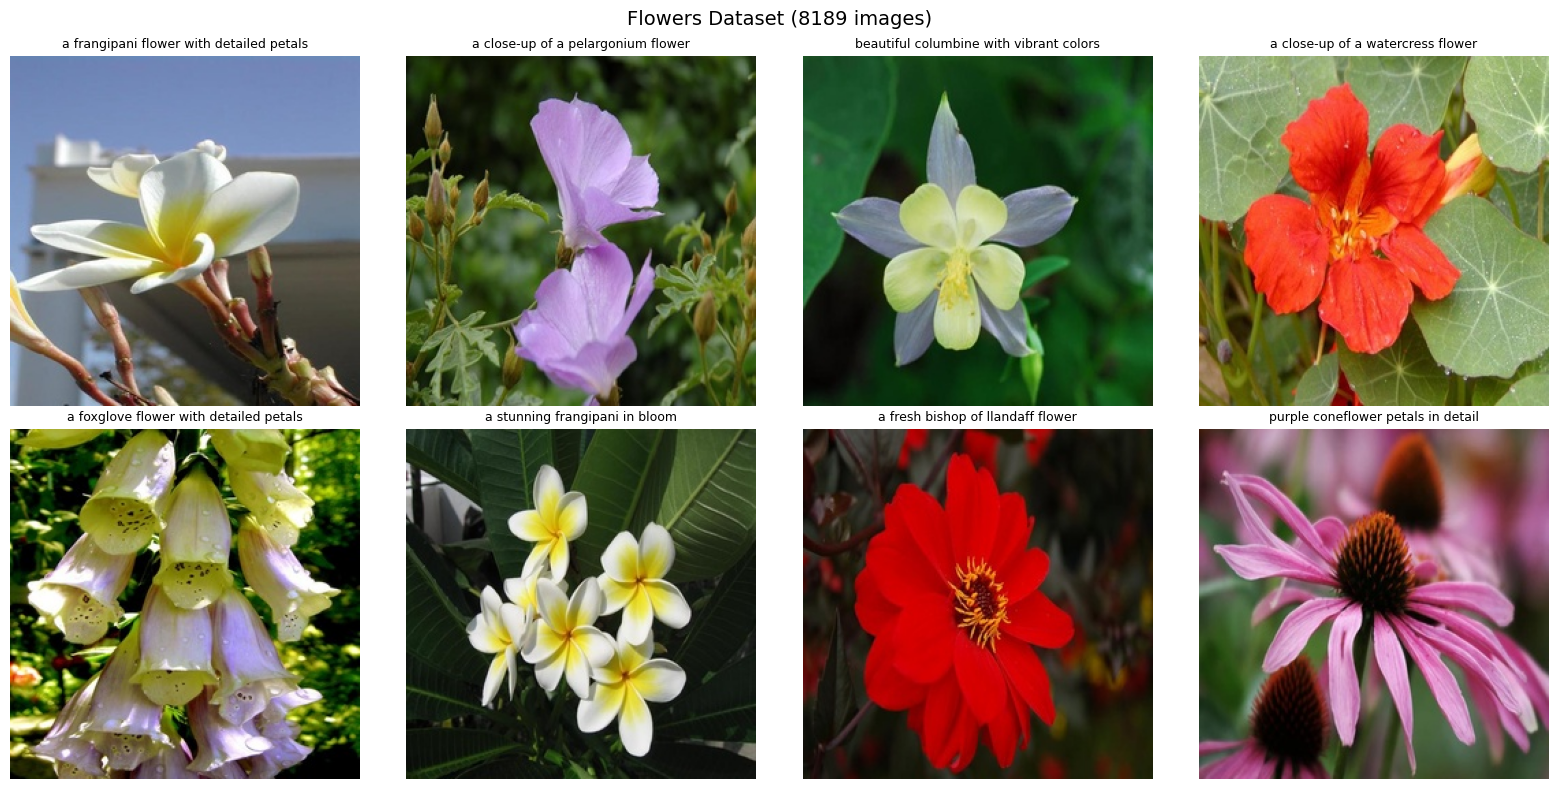

In [5]:
# ===== FINAL VERIFICATION =====

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset_path = '/content/drive/MyDrive/flowers_dataset'

jpg_files = sorted(list(Path(dataset_path).glob('*.jpg')))
txt_files = sorted(list(Path(dataset_path).glob('*.txt')))

print("="*60)
print("FINAL DATASET VERIFICATION")
print("="*60)
print(f"  JPG files: {len(jpg_files)}")
print(f"  TXT files: {len(txt_files)}")

if len(jpg_files) >= 8000:
    print(f"  Status: ✓ COMPLETE!")
elif len(jpg_files) >= 7000:
    print(f"  Status: ⚠️ Mostly complete ({len(jpg_files)}/8189)")
else:
    print(f"  Status: ❌ INCOMPLETE - Run download again!")

print("="*60)

# Sample captions
print("\nSample captions:")
for i in random.sample(range(len(txt_files)), min(8, len(txt_files))):
    caption = txt_files[i].read_text().strip()
    print(f"  {caption}")

# Show images
if len(jpg_files) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, idx in zip(axes.flatten(), random.sample(range(len(jpg_files)), 8)):
        img = Image.open(jpg_files[idx])
        caption = jpg_files[idx].with_suffix('.txt').read_text().strip()
        ax.imshow(img)
        ax.set_title(caption, fontsize=9)
        ax.axis('off')
    plt.suptitle(f"Flowers Dataset ({len(jpg_files)} images)", fontsize=14)
    plt.tight_layout()
    plt.show()